# Clustering NBA Players Based on 2-Game Rolling Averages


# Setup
We will begin by importing necessary libraries. The purpose of this notebook is to test, evaluate and compare different clustering algorithms for training prediction models later on.

## Imports

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## Load Data and Ensure unique player IDs

In [5]:
season_22_23 = pd.read_csv('/content/NBA-Fantasy-Points-Prediction/data/processed/Season(2022-23)_cleaned.csv')
season_23_24 = pd.read_csv('/content/NBA-Fantasy-Points-Prediction/data/processed/Season(2023-24)_cleaned.csv')

season_22_23['Season'] = '2022-23'
season_23_24['Season'] = '2023-24'

def get_unique_ids(df):
  unique_ids = df.groupby('Name')['id'].nunique()
  players_with_multiple_ids = unique_ids[unique_ids > 1]
  return players_with_multiple_ids

season_22_23_ids = get_unique_ids(season_22_23)
season_23_24_ids = get_unique_ids(season_23_24)

print(season_22_23_ids)
print(season_23_24_ids)

Series([], Name: id, dtype: int64)
Series([], Name: id, dtype: int64)


## Calculate 2-game rolling averages

In [6]:
stats_columns = ['FG', 'FGA', 'FG%', '3P', '3PA', '3P%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'GmSc', '+-', 'fpts_fanduel']

def calculate_rolling_avg(df):
  df.sort_values(by=['id', 'Date'], inplace=True)
  grouped = df.groupby('id')
  for column in stats_columns:
    rolling_means = grouped[column].rolling(window=2).mean().shift(1)
    rolling_means = rolling_means.reset_index(level=0, drop=True)
    df[f'{column}_2game_avg'] = rolling_means
  df.loc[df.groupby('id').head(1).index, [f'{column}_2game_avg' for column in stats_columns]] = pd.NA
  return df

season_22_23 = calculate_rolling_avg(season_22_23)
season_23_24 = calculate_rolling_avg(season_23_24)

df = pd.concat([season_22_23, season_23_24], ignore_index=True)


## Convert MP to total minutes as floating values

In [7]:
# Convert MM:SS format to total minutes as float
def convert_mp_to_minutes(mp_str):
  if isinstance(mp_str, str):
    minutes, seconds = map(int, mp_str.split(':'))
    return minutes + seconds / 60.0
  return 0

pd.set_option('display.max_columns', None)
df['MP'] = df['MP'].apply(convert_mp_to_minutes)
df['Date'] = pd.to_datetime(df['Date'])
df.dtypes.to_frame().T

,Date,Name,Team,MP,FG,FGA,FG%,3P,3PA,3P%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,GmSc,+-,TeamAbbr,GameLink,Opponent,Home,GameType,id,fpts_fanduel,Season,FG_2game_avg,FGA_2game_avg,FG%_2game_avg,3P_2game_avg,3PA_2game_avg,3P%_2game_avg,FT_2game_avg,FTA_2game_avg,FT%_2game_avg,ORB_2game_avg,DRB_2game_avg,TRB_2game_avg,AST_2game_avg,STL_2game_avg,BLK_2game_avg,TOV_2game_avg,PF_2game_avg,PTS_2game_avg,GmSc_2game_avg,+-_2game_avg,fpts_fanduel_2game_avg
0,datetime64[ns],object,object,float64,int64,int64,float64,int64,int64,float64,int64,int64,float64,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,int64,object,object,object,int64,object,int64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64


## Display Data

In [22]:
df = df.sort_values(by='Date')
df.fillna(method='ffill', inplace=True)
df.dropna(inplace=True)
na_values = df.isnull().sum().sum()
print(f"NaN count: {na_values}")
print(df.shape)
df.head()

NaN count: 0
(55391, 53)


,Date,Name,Team,MP,FG,FGA,FG%,3P,3PA,3P%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,GmSc,+-,TeamAbbr,GameLink,Opponent,Home,GameType,id,fpts_fanduel,Season,FG_2game_avg,FGA_2game_avg,FG%_2game_avg,3P_2game_avg,3PA_2game_avg,3P%_2game_avg,FT_2game_avg,FTA_2game_avg,FT%_2game_avg,ORB_2game_avg,DRB_2game_avg,TRB_2game_avg,AST_2game_avg,STL_2game_avg,BLK_2game_avg,TOV_2game_avg,PF_2game_avg,PTS_2game_avg,GmSc_2game_avg,+-_2game_avg,fpts_fanduel_2game_avg
9912,2022-10-22,dorian finney-smith,Dallas Mavericks,27.116667,3,6,0.500,1,4,0.250,0,1,0.0,3,2,5,1,1,1,1,2,7,6.9,28,DAL,https://www.basketball-reference.com/boxscores...,Memphis Grizzlies,1,Season,20001757,19.5,2022-23,1.0,3.0,0.2500,0.0,1.5,0.000,0.5,1.0,0.25,0.0,2.0,2.0,1.5,1.0,0.0,1.0,1.0,2.5,1.85,-1.0,9.15
17174,2022-10-22,isaiah roby,San Antonio Spurs,13.800000,1,2,0.500,0,0,0.000,0,0,0.0,2,2,4,2,1,1,0,2,2,5.3,7,SAS,https://www.basketball-reference.com/boxscores...,Philadelphia 76ers,0,Season,20002297,15.8,2022-23,0.5,1.5,0.1665,0.0,0.0,0.000,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.5,0.5,1.5,1.0,-0.60,1.0,2.00
18248,2022-10-22,max strus,Miami Heat,37.116667,8,14,0.571,3,7,0.429,1,1,1.0,0,5,5,3,0,2,0,1,20,18.0,-2,MIA,https://www.basketball-reference.com/boxscores...,Toronto Raptors,1,Season,20002343,36.5,2022-23,4.0,7.0,0.4890,2.5,5.0,0.357,1.5,2.5,0.30,0.5,3.5,4.0,1.0,0.0,0.0,1.5,2.0,12.0,8.10,-11.0,16.80
2762,2022-10-22,robin lopez,Cleveland Cavaliers,15.616667,6,7,0.857,0,0,0.000,0,0,0.0,1,2,3,0,0,1,0,1,12,11.1,19,CLE,https://www.basketball-reference.com/boxscores...,Chicago Bulls,0,Season,20000618,18.6,2022-23,4.0,7.0,0.4890,2.5,5.0,0.357,1.5,2.5,0.30,0.5,3.5,4.0,1.0,0.0,0.0,1.5,2.0,12.0,8.10,-11.0,16.80
7379,2022-10-22,raul neto,Cleveland Cavaliers,15.200000,3,5,0.600,0,1,0.000,0,0,0.0,0,4,4,4,1,0,1,1,6,7.3,11,CLE,https://www.basketball-reference.com/boxscores...,Chicago Bulls,0,Season,20001434,18.8,2022-23,4.0,7.0,0.4890,2.5,5.0,0.357,1.5,2.5,0.30,0.5,3.5,4.0,1.0,0.0,0.0,1.5,2.0,12.0,8.10,-11.0,16.80


In [48]:
df['PTS_per_FGA_2game_avg']  = df['PTS_2game_avg'] / df['FGA_2game_avg']
df.head()

,Date,Name,Team,MP,FG,FGA,FG%,3P,3PA,3P%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,GmSc,+-,TeamAbbr,GameLink,Opponent,Home,GameType,id,fpts_fanduel,Season,FG_2game_avg,FGA_2game_avg,FG%_2game_avg,3P_2game_avg,3PA_2game_avg,3P%_2game_avg,FT_2game_avg,FTA_2game_avg,FT%_2game_avg,ORB_2game_avg,DRB_2game_avg,TRB_2game_avg,AST_2game_avg,STL_2game_avg,BLK_2game_avg,TOV_2game_avg,PF_2game_avg,PTS_2game_avg,GmSc_2game_avg,+-_2game_avg,fpts_fanduel_2game_avg,PTS_per_FGA_2game_avg
9912,2022-10-22,dorian finney-smith,Dallas Mavericks,27.116667,3,6,0.500,1,4,0.250,0,1,0.0,3,2,5,1,1,1,1,2,7,6.9,28,DAL,https://www.basketball-reference.com/boxscores...,Memphis Grizzlies,1,Season,20001757,19.5,2022-23,1.0,3.0,0.2500,0.0,1.5,0.000,0.5,1.0,0.25,0.0,2.0,2.0,1.5,1.0,0.0,1.0,1.0,2.5,1.85,-1.0,9.15,0.833333
17174,2022-10-22,isaiah roby,San Antonio Spurs,13.800000,1,2,0.500,0,0,0.000,0,0,0.0,2,2,4,2,1,1,0,2,2,5.3,7,SAS,https://www.basketball-reference.com/boxscores...,Philadelphia 76ers,0,Season,20002297,15.8,2022-23,0.5,1.5,0.1665,0.0,0.0,0.000,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.5,0.5,1.5,1.0,-0.60,1.0,2.00,0.666667
18248,2022-10-22,max strus,Miami Heat,37.116667,8,14,0.571,3,7,0.429,1,1,1.0,0,5,5,3,0,2,0,1,20,18.0,-2,MIA,https://www.basketball-reference.com/boxscores...,Toronto Raptors,1,Season,20002343,36.5,2022-23,4.0,7.0,0.4890,2.5,5.0,0.357,1.5,2.5,0.30,0.5,3.5,4.0,1.0,0.0,0.0,1.5,2.0,12.0,8.10,-11.0,16.80,1.714286
2762,2022-10-22,robin lopez,Cleveland Cavaliers,15.616667,6,7,0.857,0,0,0.000,0,0,0.0,1,2,3,0,0,1,0,1,12,11.1,19,CLE,https://www.basketball-reference.com/boxscores...,Chicago Bulls,0,Season,20000618,18.6,2022-23,4.0,7.0,0.4890,2.5,5.0,0.357,1.5,2.5,0.30,0.5,3.5,4.0,1.0,0.0,0.0,1.5,2.0,12.0,8.10,-11.0,16.80,1.714286
7379,2022-10-22,raul neto,Cleveland Cavaliers,15.200000,3,5,0.600,0,1,0.000,0,0,0.0,0,4,4,4,1,0,1,1,6,7.3,11,CLE,https://www.basketball-reference.com/boxscores...,Chicago Bulls,0,Season,20001434,18.8,2022-23,4.0,7.0,0.4890,2.5,5.0,0.357,1.5,2.5,0.30,0.5,3.5,4.0,1.0,0.0,0.0,1.5,2.0,12.0,8.10,-11.0,16.80,1.714286


# Data Prep for Clustering
We will prepare the data for clustering. This includes selecting the relevant features (2 game rolling averages for each player), handling any missing values, and scaling the features to ensure they contribute equally to the clustering process.


In [49]:
# TODO - CALCULATE new VIF with new 'PTS_per_FGA_2game_avg' feature
features_for_clustering = [
    'FG_2game_avg', 'FGA_2game_avg', 'FG%_2game_avg', '3P_2game_avg',
    '3PA_2game_avg', '3P%_2game_avg', 'FT_2game_avg', 'FTA_2game_avg',
    'FT%_2game_avg', 'ORB_2game_avg', 'DRB_2game_avg', 'AST_2game_avg',
    'STL_2game_avg', 'BLK_2game_avg', 'TOV_2game_avg', 'PF_2game_avg',
    'PTS_2game_avg', 'GmSc_2game_avg', 'PTS_per_FGA_2game_avg'
]

X_clustering = df[features_for_clustering]

missing_values = X_clustering.isnull().sum()
print("Missing values per feature:\n", missing_values)

Missing values per feature:
 FG_2game_avg               0
FGA_2game_avg              0
FG%_2game_avg              0
3P_2game_avg               0
3PA_2game_avg              0
3P%_2game_avg              0
FT_2game_avg               0
FTA_2game_avg              0
FT%_2game_avg              0
ORB_2game_avg              0
DRB_2game_avg              0
AST_2game_avg              0
STL_2game_avg              0
BLK_2game_avg              0
TOV_2game_avg              0
PF_2game_avg               0
PTS_2game_avg              0
GmSc_2game_avg             0
PTS_per_FGA_2game_avg    613
dtype: int64


In [46]:
X_clustering = X_clustering.drop(['FG_2game_avg', 'GmSc_2game_avg', '3P_2game_avg', 'FT_2game_avg'], axis=1)

X_vif = X_clustering.copy()

X_vif['Intercept'] = 1

vif = pd.DataFrame()
vif['Feature'] = X_vif.columns
vif['VIF'] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

print(vif)

          Feature        VIF
0   FGA_2game_avg  14.882062
1   FG%_2game_avg   2.035745
2   3PA_2game_avg   3.248529
3   3P%_2game_avg   1.702195
4   FTA_2game_avg   3.722160
5   FT%_2game_avg   1.976814
6   ORB_2game_avg   1.565508
7   DRB_2game_avg   1.938785
8   AST_2game_avg   1.844277
9   STL_2game_avg   1.215901
10  BLK_2game_avg   1.251729
11  TOV_2game_avg   1.841745
12   PF_2game_avg   1.317102
13  PTS_2game_avg  19.615044
14      Intercept  12.054612


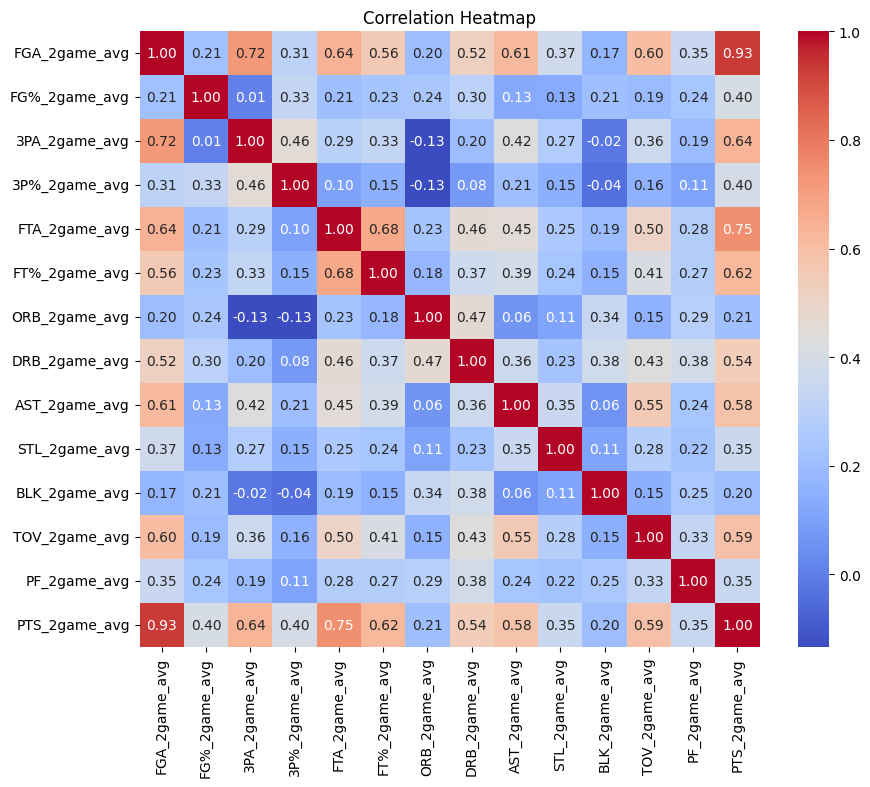

'\nHighly correlated features (> 0.9):\n------------------\nFG, FGA   ---> 0.93\nFG, PTS   ---> 0.98\nFG, GmSc  ---> 0.93\nFGA, PTS  ---> 0.93\n3P, 3PA   ---> 0.87\nFT, FTA   ---> 0.97\nGmSc, PTS ---> 0.94\n------------------\n\ndrop FG, GmSc, 3P, FT\n'

In [47]:
correlation_matrix = X_clustering.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

"""
Highly correlated features (> 0.9):
------------------
FG, FGA   ---> 0.93
FG, PTS   ---> 0.98
FG, GmSc  ---> 0.93
FGA, PTS  ---> 0.93
3P, 3PA   ---> 0.87
FT, FTA   ---> 0.97
GmSc, PTS ---> 0.94
------------------

drop FG, GmSc, 3P, FT
"""

# Save Colab notebook and push to Github Repo

In [36]:
import os
from getpass import getpass

if not os.path.exists('/content/drive'):
  from google.colab import drive
  drive.mount('/content/drive')
else:
  print("Google Drive already mounted")


token = getpass('Enter your GitHub token: ')

!git config --global user.email "swghazzawi@gmail.com"
!git config --global user.name "sammig6i"

repo_path = '/content/NBA-Fantasy-Points-Prediction'
if not os.path.exists(repo_path):
  !git clone https://{token}@github.com/sammig6i/NBA-Fantasy-Points-Prediction.git
else:
  print("Repo already cloned, pulling the latest changes")
  %cd /content/NBA-Fantasy-Points-Prediction
  !git pull https://{token}@github.com/sammig6i/NBA-Fantasy-Points-Prediction.git

!cp /content/drive/MyDrive/NBA_Fantasy_Clustering.ipynb /content/NBA-Fantasy-Points-Prediction/notebooks/

%cd {repo_path}

!git add notebooks/NBA_Fantasy_Clustering.ipynb

!git commit -m "Add clustering notebook for NBA Fantasy project"

!git push https://{token}@github.com/sammig6i/NBA-Fantasy-Points-Prediction.git


Google Drive already mounted
Enter your GitHub token: ··········
Repo already cloned, pulling the latest changes
/content/NBA-Fantasy-Points-Prediction
From https://github.com/sammig6i/NBA-Fantasy-Points-Prediction
 * branch            HEAD       -> FETCH_HEAD
Already up to date.
/content/NBA-Fantasy-Points-Prediction
[main 704149d] Add clustering notebook for NBA Fantasy project
 1 file changed, 1 insertion(+), 1 deletion(-)
Enumerating objects: 7, done.
Counting objects: 100% (7/7), done.
Delta compression using up to 2 threads
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 859 bytes | 859.00 KiB/s, done.
Total 4 (delta 3), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
To https://github.com/sammig6i/NBA-Fantasy-Points-Prediction.git
   8ead996..704149d  main -> main
